In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.concept_utils import conceptExample
import numpy as np

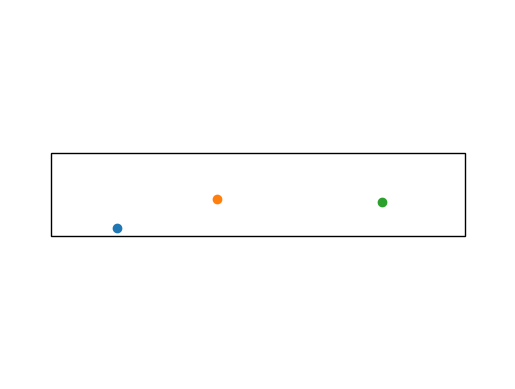

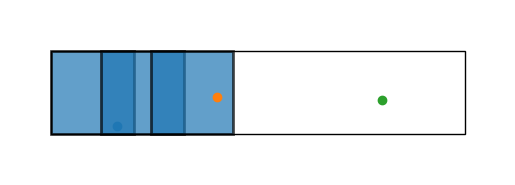

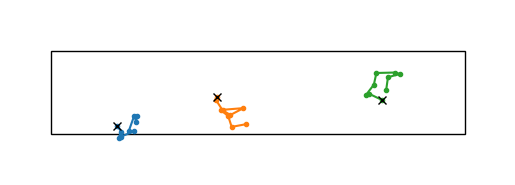

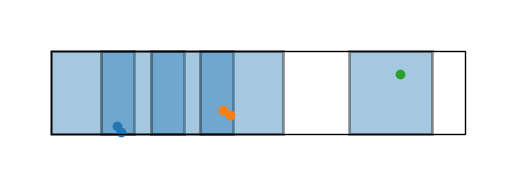

In [4]:
ce = conceptExample()

ce.plot_starting()
ce.plot_cams()
ce.plot_paths()
ce.plot_detections()


In [5]:
ce.df

,time,individual,x,y
0,0,0,0.800000,0.089907
1,1,0,0.847174,0.022477
2,2,1,2.071139,0.283398
3,3,1,2.166491,0.226188
4,6,2,4.213653,0.722415


In [6]:
def step_tracks(t, tracks, ce):
    det = ce.df[ce.df["time"]==t]
    return ce.update_tracks(det, tracks)

In [9]:
tracks = ce.make_first_track()

In [10]:
tracks

[[0], [nan]]

In [14]:
a = [1,2]
np.multiply(*a)

2

In [8]:
tracks1 = step_tracks(1, tracks, ce)
tracks2 = step_tracks(2, tracks1, ce)
tracks3 = step_tracks(3, tracks2, ce)
tracks4 = step_tracks(4, tracks3, ce)

In [38]:
tracks2

[[0, nan, nan],
 [0, nan, 2],
 [0, 1, nan],
 [0, 1, 2],
 [nan, nan, nan],
 [nan, nan, 2],
 [nan, 1, nan],
 [nan, 1, 2]]

In [25]:
tracks7 = step_tracks(5, tracks4, ce)

In [31]:
for i, t in enumerate(tracks4):
    print(t, tracks7[i])

[0, nan, nan, nan, nan] [0, nan, nan, nan, nan, nan]
[0, nan, nan, 3, nan] [0, nan, nan, 3, nan, nan]
[0, nan, nan, 3, 4] [0, nan, nan, 3, 4, nan]
[0, nan, 2, nan, nan] [0, nan, 2, nan, nan, nan]
[0, nan, 2, nan, 4] [0, nan, 2, nan, 4, nan]
[0, nan, 2, 3, nan] [0, nan, 2, 3, nan, nan]
[0, nan, 2, 3, 4] [0, nan, 2, 3, 4, nan]
[0, 1, nan, nan, nan] [0, 1, nan, nan, nan, nan]
[0, 1, nan, nan, 4] [0, 1, nan, nan, 4, nan]
[0, 1, nan, 3, nan] [0, 1, nan, 3, nan, nan]
[0, 1, nan, 3, 4] [0, 1, nan, 3, 4, nan]
[0, 1, 2, nan, nan] [0, 1, 2, nan, nan, nan]
[0, 1, 2, nan, 4] [0, 1, 2, nan, 4, nan]
[0, 1, 2, 3, nan] [0, 1, 2, 3, nan, nan]
[0, 1, 2, 3, 4] [0, 1, 2, 3, 4, nan]
[nan, nan, nan, nan, nan] [nan, nan, nan, nan, nan, nan]
[nan, nan, nan, nan, 4] [nan, nan, nan, nan, 4, nan]
[nan, nan, nan, 3, nan] [nan, nan, nan, 3, nan, nan]
[nan, nan, nan, 3, 4] [nan, nan, nan, 3, 4, nan]
[nan, nan, 2, nan, nan] [nan, nan, 2, nan, nan, nan]
[nan, nan, 2, nan, 4] [nan, nan, 2, nan, 4, nan]
[nan, nan, 2, 3

In [10]:
tracks

[[0, nan, nan],
 [0, nan, 2],
 [0, 1, nan],
 [0, 1, 2],
 [nan, nan, nan],
 [nan, nan, 2],
 [nan, 1, nan],
 [nan, 1, 2]]

In [11]:
ta = np.array(tracks)

In [12]:
np.unique(ta[:, 2])

array([ 2., nan, nan, nan, nan])